In [1]:
import tqdm

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np


In [2]:
COVIDDataPath = Path('data') / 'data_2021-May-13.csv'

sc = ['date', 'newCasesBySpecimenDate']
df = pd.read_csv(COVIDDataPath)
df = df[sc]
df.columns = ['Date', 'NewCases']
df.Date = pd.to_datetime(df.Date)
df = df.sort_values('Date').reset_index(drop=True)
df = df.iloc[30:-14]

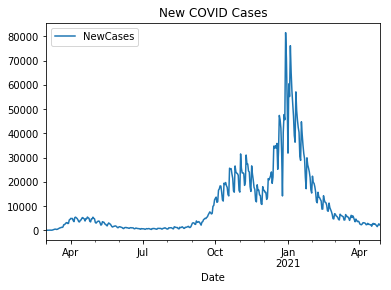

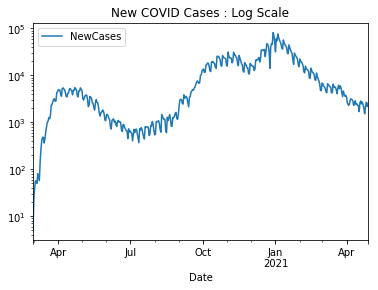

In [3]:
df.set_index('Date').plot()
plt.title('New COVID Cases')
df.set_index('Date').plot(logy=True)
plt.title('New COVID Cases : Log Scale')
plt.show()

In [104]:
from kalman import getConditionalLogLikelihood
from kalman import getApproxParameters
from kalman import KalmanSmoother

### Randomly initialise parameters
numStates = 3
A = np.asarray([[1, 1, 0],[0,1,0], [0, 0, 0]])
C = np.asarray([[1,0, 1]])
n = 1
Qhat = 2*np.eye(numStates) #np.eye(numStates)
Ahat = np.diag(np.random.normal(0,1,numStates)) # A
Chat = np.zeros((n, numStates)) # C
Chat[0][0] = 1
Rhat = 10*np.eye(n) # np.cov(y).reshape(y.shape[0], y.shape[0])
zStart = np.zeros((numStates, 1))
Sigma = np.eye(numStates)*30
params = []
y = np.log10(df['NewCases'].to_numpy()).reshape(1,-1)
Ahat, Chat = A,C
### training
# zStart = z[:,0:1]

for it in tqdm.tqdm(range(200)):
    ### E-step : get smoothed probabilities
    ztT, PtT, Pt1tT, zt1t, Pt1t, ztt, zt1t = KalmanSmoother(y[:,1:], Ahat, Chat, Qhat, Rhat, zStart, Sigma)
    # zStart = ztT[:,0:1]

    ### M-step : optimize parameters
    Ahat, Chat, Qhat, Rhat = getApproxParameters(ztT, PtT, Pt1tT, y[:,1:], A=A) # A=A, C=C 
    
    ### Conditional likelihood p(Y|theta)
    ll = getConditionalLogLikelihood(y[:,1:], zt1t, Pt1t, Chat, Rhat)
    
    dct = {'A':Ahat,'C':Chaw t,'Q':Qhat,'R':Rhat, 'zStart':zStart, 'll':ll}
    params.append(dct)


100%|██████████| 200/200 [00:09<00:00, 20.04it/s]


1.7595376222158647


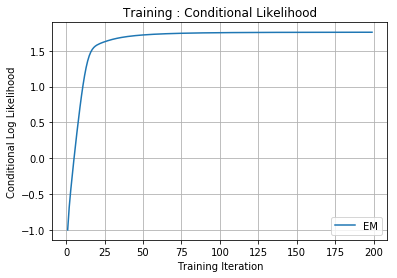

In [113]:
loglikelihoodDF = pd.DataFrame(params)[['ll']].loc[1:]
print(loglikelihoodDF.max()[0])
loglikelihoodDF.plot();
plt.ylabel('Conditional Log Likelihood')
plt.xlabel('Training Iteration')
# plt.xticks(df.index.astype(int))
# plt.axhline(y = optimalLL, color = 'r', linestyle = '-')
plt.grid()
plt.title('Training : Conditional Likelihood')
plt.legend(['EM', 'Actual Parameters'])
plt.show()


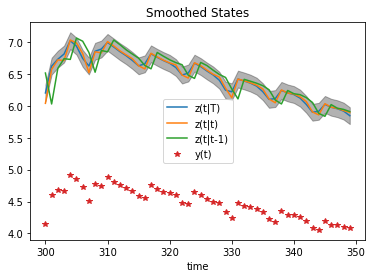

In [114]:
Tmin = 300
Tmax = 350

x = np.linspace(Tmin,Tmax-1, Tmax-Tmin)
plt.figure()
plt.fill_between(x, ztT[0,Tmin:Tmax].T-2*PtT[0,0,Tmin:Tmax].T**0.5, ztT[0,Tmin:Tmax].T+2*PtT[0,0,Tmin:Tmax]**0.5, edgecolor='black', facecolor='k', alpha=0.3)
plt.plot(x, ztT[0,Tmin:Tmax].T)
plt.plot(x, ztt[0,Tmin:Tmax].T)
plt.plot(x, zt1t[0,Tmin-1:Tmax-1].T)
plt.plot(x, y[0,Tmin:Tmax].T, '*')
plt.xlabel('time')
plt.title('Smoothed States')
plt.legend(['z(t|T)', 'z(t|t)', 'z(t|t-1)', 'y(t)'])
plt.show()


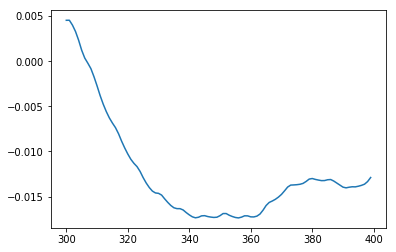

In [111]:
plt.plot(x, ztT[1,Tmin:Tmax].T)